# **Assessment 1**

For our first assessment, our goal is to solve an imputation problem: we will create a neural network architecture that learns how to recover missing portions of an image.

This is an important problem in magnetic resonance imaging (MRI), where patient scans are often limited to a few areas to avoid lengthy scanning times.

In particular, we are going to focus on images of human heads. We have managed to gain access to one hundred images of patient's heads but, unfortunately, these images have a significant portion of missing information. Your goal during the assessment is to design a neural network that can recover these missing portions.

<br>

---

<br>

We do not have access to the labels for the images we want to recover, so we will have to be a bit creative to obtain a workable dataset on which to train our neural network.

Fortunately for us, we have access to a generative model that has been trained to produce realistic-looking MRI images of patient's heads. Using this model, you will create an appropriate dataset to train your architecture. We have provided you with the basic setup code to start using this generative model in **Question 1** below.

The corrupted images that we want to recover are contained in the numpy file `test_set.npy` of this repository. The file contains 100 patient images with a size of 64x64 pixels.

The architecture that you design in this assessment should use the artificially-generated dataset in order to recover the missing information in the images contained in `test_set.npy`.

<br>

All answers to the assessment should be contained within the structure below, but you are free to add new code and text cells as required to your answers. Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

Please, **make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

<br>

---

<br>

<br><br>

## **Question 1**  (25%)

Using the provided image-generation network, create a dataset of brain images that will later be used to train your chosen architecture.

Given that you will likely want to use this dataset multiple times during training, we recommend that you save the generated images to an appropriate folder in your GDrive.

Once you have generated your dataset, load and display ten of your generated images here.

We have also provided you with some corrupted images in the file `test_set.npy` of this repository. You should also load and display ten of these corrupted images here.

Below, we have provided template code, including some required downloads and installations, so that you can easily use the trained generative model. Sample generation in this model is done using the function `generate`, and is controlled by some input arguments. It is your job to figure out a sensible set of parameters that will produce images that are useful for the requirements of your task.

<br>

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [2]:
!pip install pycm livelossplot
%pylab inline

import os
import sys
import torch
import torch.nn as nn
import numpy as np
import random
from torchvision import transforms
from tqdm import tqdm
from torchvision.transforms import Lambda
import torchvision
from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from torch.utils.data import random_split

import matplotlib.pyplot as plt

!pip install torch-summary progressbar2 -q

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.6/608.6 kB 16.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-40GB!


In [3]:
# Pull and install necessary files
# !unzip /content/drive/MyDrive/cw1_files.zip -d ./
# !chmod +x run.sh
# !bash ./run.sh
# sys.path.append('/content/ese-invldm')

Archive:  /content/drive/MyDrive/cw1_files.zip
  inflating: ./files/config_training.yml  
  inflating: ./run.sh                
  inflating: ./ese-invldm/setup.py   
  inflating: ./files/default_config.yml  
  inflating: ./ese-invldm/ese_invldm/ese_invldm.py  
  inflating: ./ese-invldm/ese_invldm/__init__.py  
  inflating: ./files/autoencoder/autoencoder_ckpt_latest.pth  
  inflating: ./files/diffusion/diffusion_ckpt_latest.pth  
Cloning the repository from https://github.com/dpelacani/InverseLDM.git...
Cloning into 'InverseLDM'...
remote: Enumerating objects: 1331, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1331 (delta 167), reused 182 (delta 100), pack-reused 1070 (from 1)
Receiving objects: 100% (1331/1331), 467.16 KiB | 4.41 MiB/s, done.
Resolving deltas: 100% (875/875), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 409.0 kB/s eta 0:00:00
   ━━━━━━

In [4]:
# from ese_invldm import generate

"""
Generates samples using a diffusion-based generative model.

This function leverages a pre-configured diffusion model to produce synthetic samples.
The sampling process supports adjustable parameters for total samples, inference steps, and batch size.
A scheduler and temperature can also be configured to control the sampling behaviour.

Parameters:
    num_samples (int):
        Total number of samples to generate.
    num_inference_steps (int):
        Number of diffusion inference steps.
        The minimum number of steps is 1, but we recommend exploring the range from 10 to 50.
        Please note that more steps will increase quality but also the computational cost. Be careful not
        to burn through your credits by using a very large number of steps!
    batch_size (int):
        Number of samples to process in each batch during sampling.
    scheduler (str, optional):
        Sampling scheduler to use (e.g., "ddim", "ddpm"). You can quickly test which one provides the most appropriate results
        for this task.
    temperature (float, optional):
        Sampling temperature to control randomness, given as a number between 0 and 1. Higher values produce more diverse outputs.
    seed (int, optional):
        Random seed for reproducibility. Defaults to 42.

Returns:
    list:
        A list containing the batches of generated samples, where each sample
        corresponds to a single data instance produced by the diffusion model.

"""

# samples = generate(num_samples= 10240,num_inference_steps= 45, batch_size= 64, scheduler= 'ddim', temperature=0.75, seed=42)

/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/InverseLDM/invldm/runners/base_runner.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. T

Batch 0


100%|██████████| 45/45 [00:05<00:00,  7.79it/s]


Batch 1


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 2


100%|██████████| 45/45 [00:05<00:00,  8.28it/s]


Batch 3


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 4


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 5


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 6


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 7


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 8


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 9


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 10


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 11


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 12


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 13


100%|██████████| 45/45 [00:05<00:00,  8.32it/s]


Batch 14


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 15


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 16


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 17


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 18


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 19


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 20


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 21


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 22


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 23


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 24


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 25


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 26


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 27


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 28


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 29


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 30


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Batch 31


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 32


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 33


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 34


100%|██████████| 45/45 [00:05<00:00,  8.32it/s]


Batch 35


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 36


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 37


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 38


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 39


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 40


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 41


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 42


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 43


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 44


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 45


100%|██████████| 45/45 [00:05<00:00,  8.30it/s]


Batch 46


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 47


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 48


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 49


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 50


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 51


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 52


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 53


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 54


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 55


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 56


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 57


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 58


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 59


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 60


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 61


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 62


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 63


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 64


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 65


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 66


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 67


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 68


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Batch 69


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 70


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 71


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 72


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 73


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 74


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 75


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 76


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 77


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 78


100%|██████████| 45/45 [00:05<00:00,  8.33it/s]


Batch 79


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 80


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 81


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 82


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 83


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 84


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 85


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 86


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 87


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Batch 88


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 89


100%|██████████| 45/45 [00:05<00:00,  8.33it/s]


Batch 90


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 91


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 92


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 93


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 94


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 95


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 96


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 97


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 98


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 99


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 100


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 101


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Batch 102


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 103


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 104


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 105


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 106


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 107


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 108


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 109


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 110


100%|██████████| 45/45 [00:05<00:00,  8.30it/s]


Batch 111


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 112


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 113


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 114


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 115


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 116


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 117


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 118


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 119


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 120


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 121


100%|██████████| 45/45 [00:05<00:00,  8.34it/s]


Batch 122


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 123


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 124


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 125


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 126


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 127


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 128


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 129


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 130


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 131


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 132


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Batch 133


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 134


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 135


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 136


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 137


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 138


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 139


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 140


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 141


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 142


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 143


100%|██████████| 45/45 [00:05<00:00,  8.34it/s]


Batch 144


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 145


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 146


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 147


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 148


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 149


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 150


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 151


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 152


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 153


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 154


100%|██████████| 45/45 [00:05<00:00,  8.30it/s]


Batch 155


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 156


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 157


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 158


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Batch 159


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


In [5]:
print(f'Number of batches: {len(samples)}, Number of images in batch: {len(samples[0])}, Number of images in channels: {len(samples[0][0])}, Dimension: {len(samples[0][0][0])}, {len(samples[0][0][0][0])}')

Number of batches: 160, Number of images in batch: 64, Number of images in channels: 1, Dimension: 64, 64


In [6]:
# # This code was written with the help of ChatGPT

# from PIL import Image

# # The directory in Google Drive where images will be saved
# output_dir = '/content/drive/My Drive/GeneratedImages_Final'
# os.makedirs(output_dir, exist_ok=True)

# for idx, tensor in enumerate(samples):
#     # Move tensor to CPU if it is on a GPU
#     if tensor.is_cuda:
#         tensor = tensor.cpu()

#     # Iterate through each image in the batch (assuming batch size is 64)
#     for i in range(tensor.shape[0]):  # Loop over batch size
#         img = tensor[i]  # Get the i-th image in the batch

#         # Convert tensor to NumPy array
#         img_array = img.numpy().squeeze()  # Remove the channel dimension (1, H, W)

#         # Handle grayscale (H, W) format
#         if img_array.ndim == 2:  # Grayscale image (H, W)
#             pass
#         else:
#             raise ValueError(f"Unexpected image shape: {img_array.shape}")

#         # Normalize the array to 0-255 and convert to uint8
#         img_array = (img_array * 255).astype('uint8') if img_array.max() <= 1 else img_array.astype('uint8')

#         # Convert to a PIL image
#         pil_img = Image.fromarray(img_array)

#         # Save the image to Google Drive
#         image_path = os.path.join(output_dir, f'image_{idx * tensor.shape[0] + i + 1}.png')
#         pil_img.save(image_path)

# print(f"All images have been saved to: {output_dir}")

All images have been saved to: /content/drive/My Drive/GeneratedImages_Final


From the generator, we have created 10240 samples of images. While it is generally known that neural networks require large amount of data to train, the amount of data required is also dependant on the complexity of the network.

The task requires us to 'fix' or 'uncorrupt' MRI scans with missing data. However, it can be easily seen that there exists a pattern in which the data is corrupted. Furthermore, the MRI scans have only a single section view of the brain, i.e, there are no other complex views which are input into the network. Thus, the network will, in general, be able to uncorrupt the images with a small sample size to train.

On the other hand, however, the images have a lot of fine details which have to be resolved, i.e, the image themselves are complex. Thus, the network will require a fairly large amount to be able to produce sharp and defined outputs.

The 'ddim' scheduler was chosen since it outputs much clearer picture than the 'ddpm' scheduler.

The temperature value of 0.75 is chosen as we would like to have more randomised samples to train our network with a variety of images. In this case a value of 1.0 was not chosen since having a lot of variety might lead to the model not learning anything. Thus some repeatability is also desirable.

In [7]:
# This code was written with the help of ChatGPT

from PIL import Image

output_dir = '/content/drive/My Drive/GeneratedImages_Final'

# Initialize an empty list to store the batches
batches = []
batch_size = 64  # Number of images per batch

# Load each image, convert it to a tensor, and add it to the list
current_batch = []

for filename in os.listdir(output_dir):
    # Check if the file is an image (assuming .png files)
    if filename.endswith('.png'):
        image_path = os.path.join(output_dir, filename)

        # Open and convert the image to grayscale (if it's grayscale)
        img = Image.open(image_path).convert('L')  # Convert to grayscale

        # Convert image to a NumPy array (shape: H, W)
        img_array = np.array(img)

        # Normalize the image back to [0, 1] (divide by 255)
        img_tensor = torch.tensor(img_array, dtype=torch.float32) / 255.0

        # Add the tensor to the current batch (reshape it to match original tensor shape: [1, H, W])
        img_tensor = img_tensor.unsqueeze(0)  # Shape becomes [1, H, W]
        current_batch.append(img_tensor)

        # If the batch size is reached, add the batch to the list and reset the batch
        if len(current_batch) == batch_size:
            batches.append(torch.stack(current_batch))  # Stack the batch of images
            current_batch = []  # Reset the current batch

# If there are any remaining images that don't form a full batch, add them as well
if current_batch:
    batches.append(torch.stack(current_batch))  # Stack the final batch of images

# Convert the list of batches into a single tensor of shape [N, batch_size, channels, dim, dim]
# Now `batches` contains batches of images, with each batch having shape [batch_size, 1, 64, 64]
batches_tensor = torch.stack(batches)  # Shape becomes [N, batch_size, 1, 64, 64]

desired_shape = (160, 64, 1, 64, 64)

# Check if we have exactly 160 batches
if batches_tensor.shape[0] == 160:
    print(f"Final batches_tensor shape: {batches_tensor.shape}")
else:
    print(f"Warning: Expected 160 batches, but got {batches_tensor.shape[0]} batches.")

Final batches_tensor shape: torch.Size([160, 64, 1, 64, 64])


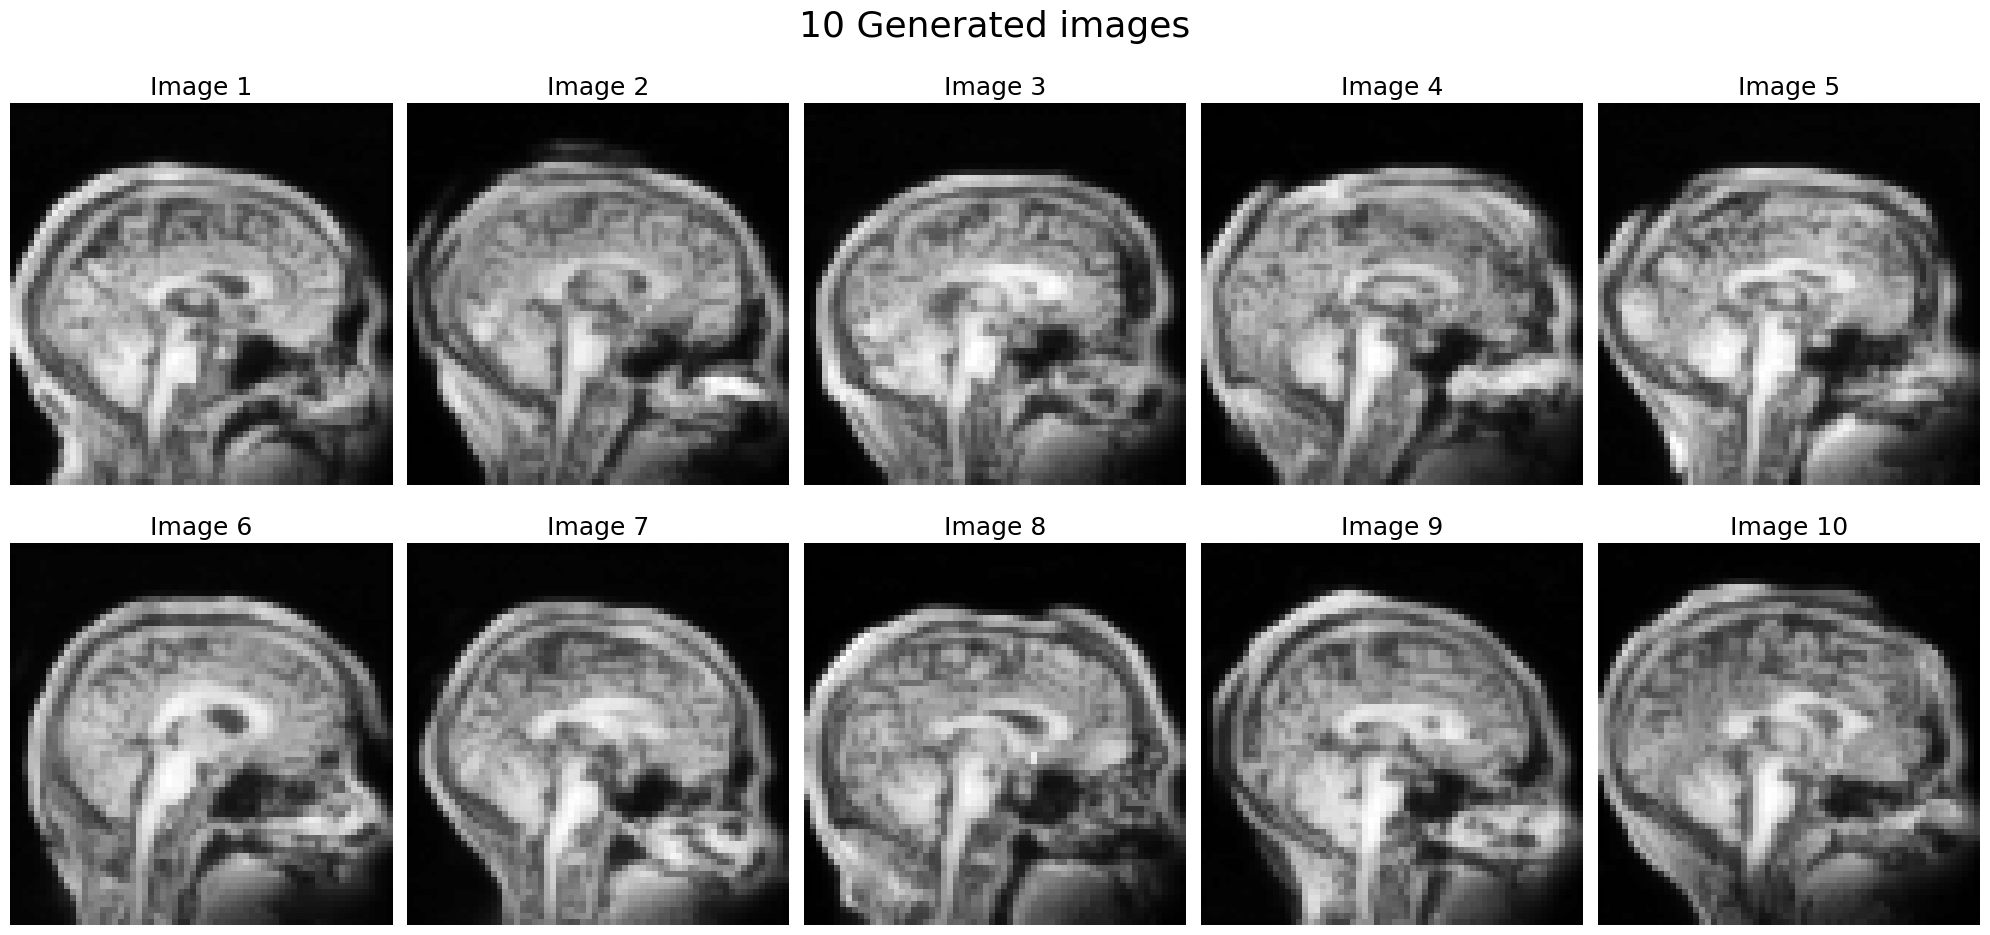

In [8]:
fig, axes = plt.subplots(2,5, figsize=(20, 10))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(batches_tensor[0][i][0], cmap='grey')
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}', fontsize=18)

fig.suptitle('10 Generated images', fontsize=26)
plt.tight_layout()
plt.show()

Shape of the test set images: (100, 1, 64, 64)
Data type: float32


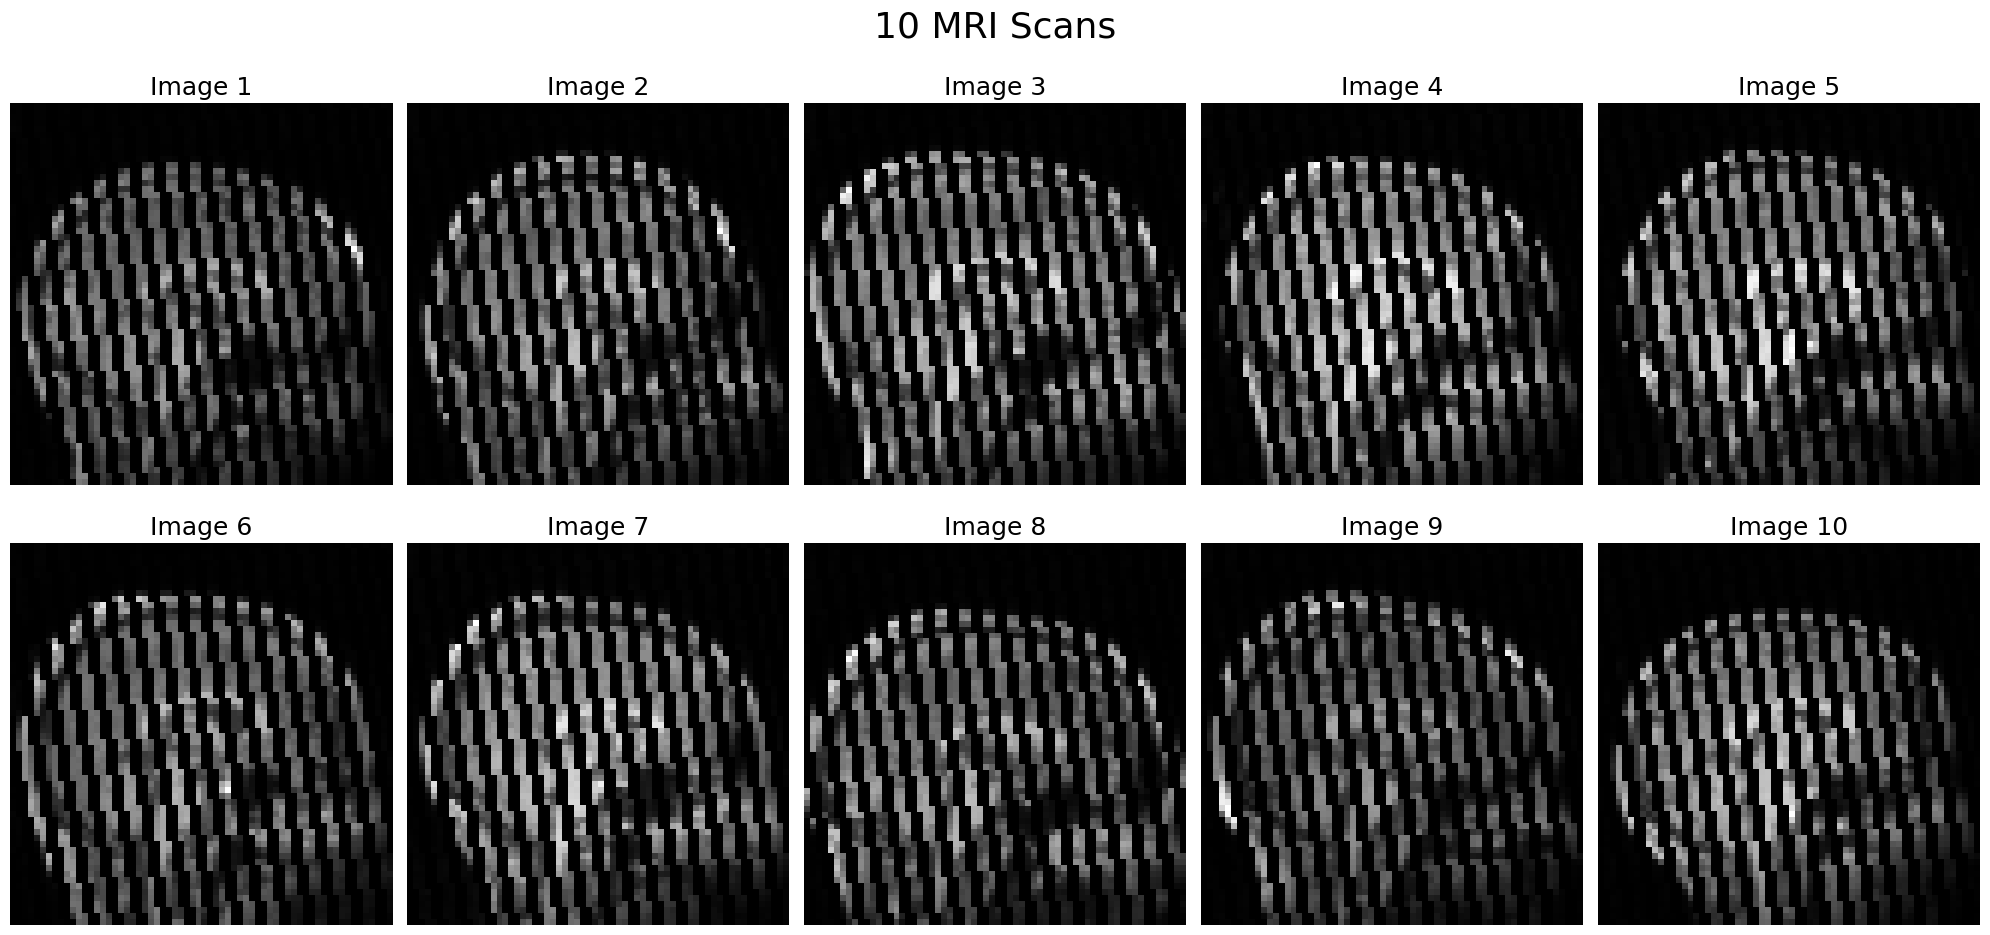

In [9]:
test_images = np.load('./drive/MyDrive/test_set.npy')
print(f'Shape of the test set images: {test_images.shape}')
print(f'Data type: {test_images.dtype}')

fig, axes = plt.subplots(2,5, figsize=(20, 10))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(test_images[i][0], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}', fontsize=18)

fig.suptitle('10 MRI Scans', fontsize=26)
plt.tight_layout()
plt.show()

In [10]:
# Statistical properties
print('Test images:')
print(f'Shape: {test_images.shape}')
print(f'Data type: {test_images.dtype}')
print("min/max:", test_images.min(), "/", test_images.max())
print("mean: ", test_images.mean())
print("std: ", test_images.std())
print(' ')
print('Generated images:')
print(f'Shape of the generated images: {batches_tensor.shape}')
print(f'Data type of the generated images: {batches_tensor.dtype}')
print("min/max:", batches_tensor.data.min().item(), "/", batches_tensor.data.max().item())
print("mean: ", torch.mean(batches_tensor.data.float()).item())
print("std: ", torch.std(batches_tensor.data.float()).item())

Test images:
Shape: (100, 1, 64, 64)
Data type: float32
min/max: 0.0 / 1.0
mean:  0.13726059
std:  0.21500342
 
Generated images:
Shape of the generated images: torch.Size([160, 64, 1, 64, 64])
Data type of the generated images: torch.float32
min/max: 0.003921568859368563 / 0.7411764860153198
mean:  0.192475825548172
std:  0.14420099556446075


<br>

---

<br>

## **Question 2**  (25%)

Using the data generated in **Question 1**, create a PyTorch `TensorDataset` and a `DataLoader` for the training set.

Using the provided corrupted images inside `test_set.npy`, create another `TensorDataset` and a `DataLoader` for the test set.

The training dataset should provide batches of brain images generated in **Question 1** and should corrupt these images appropriately so that they resemble images in the test set. The dataset should also pair each image with its corresponding un-corrupted image as a label.

The test dataset should provide the corrupted images provided, for which no labels are available.

Display here ten images of your training dataset and ten images of your test dataset, and their corresponding labels when available.

<br>





---



In order to load our data, we will create a custom dataset class for both the training and the test dataset. The reason for this is that we need to apply a filtering mask on the training dataset and normalize the values between -1,1 for the U-Net for stability. For the test dataset, we will load and convert the float32 object to a tensor object.

In [11]:
# In order to load our dataset, we will create a custom dataset class.
# Parts of this code were taken from the lecture

class MRI_test_dataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
      self.root = root
      self.transform = transform
      self.data_paths = self._get_data_paths()
      print(f"Found {len(self.data_paths)} .npy files in {self.root}")
      self.data = np.load(self.data_paths[0])

    def _get_data_paths(self, exts=(".npy")):
        data_paths = []
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if(file.endswith(exts)):
                    data_paths.append(os.path.join(root,file))
        return data_paths

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image

    def __str__(self):
        class_string = ""
        class_string += self.__class__.__name__
        class_string+="\n\tlen : %d"%self.__len__()
        for key, value in self.__dict__.items():
            if key != "data_paths" and key != "data":
                class_string+="\n\t" + str(key) + " : " + str(value)
        return class_string

Found 1 .npy files in /content/drive/MyDrive/
MRI_test_dataset
	len : 100
	root : /content/drive/MyDrive/
	transform : Compose(
    Lambda()
    Normalize(mean=(0.5,), std=(0.5,))
)


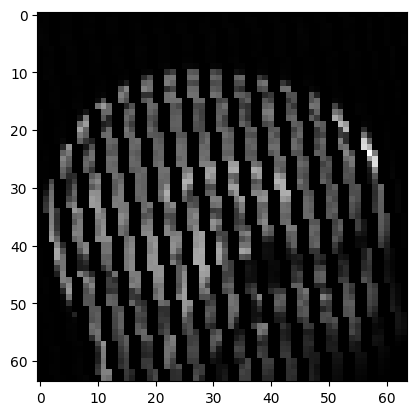

In [12]:
def to_tensor(data):
  '''
  Converts numpy array to torch tensor. Used instead of ToTensor() to avoid
    issue with swapping dimension to (64,1,64)
  '''
  return torch.from_numpy(data).type(torch.float32)

transform = transforms.Compose([
    Lambda(lambda x: to_tensor(x)),
    transforms.Normalize((0.5,), (0.5,))  # Suitable for U-Net architecture
])

test_dataset = MRI_test_dataset(root='/content/drive/MyDrive/', transform=transform)
print(test_dataset)

plt.imshow(test_dataset[0][0], cmap='gray')
plt.show()

In [13]:
def getIndex(img):
  index = []
  for i in range(64):
    for j in range(64):
      if img[i][j] == 0:
        index.append((i,j))
  return index

In [14]:
class MRI_train_dataset(torch.utils.data.Dataset):
    def __init__(self, data, ind, transform=None):
      self.data = data
      self.transform = transform
      self.ind = ind

    def __len__(self):
        return len(self.data)

    def _get_mask(self, img):
        for x, y in self.ind:
            img[:, x, y] = 0
        return img

    def __getitem__(self, idx):
        image = self.data[idx]
        masked_image = self._get_mask(image.clone())  # Clone to retain original

        if self.transform:
            image = self.transform(image)
            masked_image = self.transform(masked_image)

        return masked_image, image

    def __str__(self):
        class_string = ""
        class_string += self.__class__.__name__
        class_string+="\n\tlen : %d"%self.__len__()
        for key, value in self.__dict__.items():
            if key != "data_paths" and key != "data" and key!= "ind":
                class_string+="\n\t" + str(key) + " : " + str(value)
        return class_string

MRI_train_dataset
	len : 10240
	transform : Compose(
    Normalize(mean=(0.5,), std=(0.5,))
)


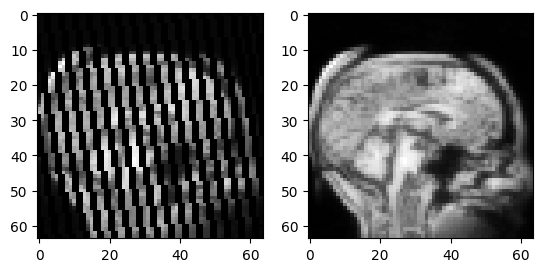

In [15]:
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # For U-Net architecture
])

data = batches_tensor.view(-1, 1, 64, 64) # Remove any batches before putting in DataLoader
ind = getIndex(test_images[0][0])
train_dataset = MRI_train_dataset(data=data, transform=transform, ind=ind)
print(train_dataset)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_dataset[11][0][0], cmap="grey")
axs[1].imshow(train_dataset[11][1][0], cmap="grey")
plt.show()

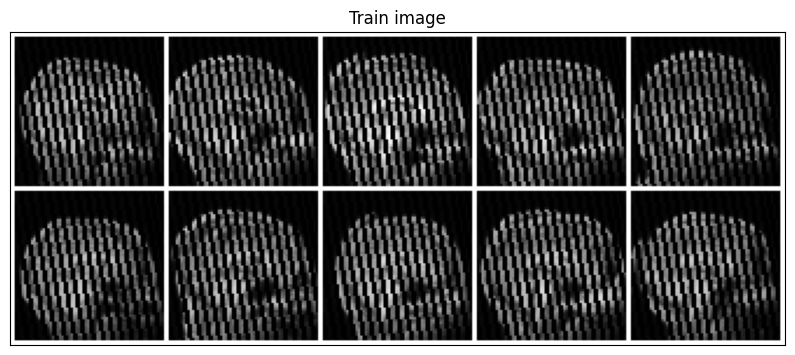

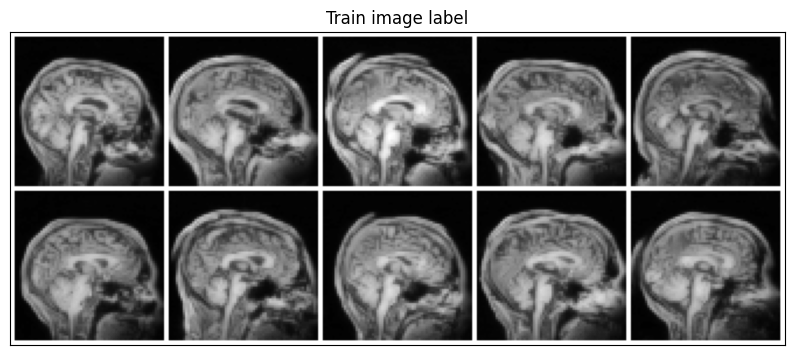

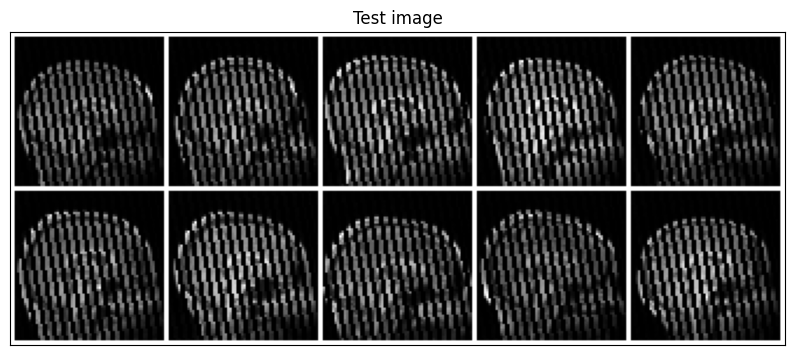

In [16]:
# Create dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input, label = next(iter(train_loader))
input = input[:10]
label = label[:10]
batch_grid = torchvision.utils.make_grid(input, nrow=5, padding=2, pad_value=input.max())
plt.figure(figsize=(10,10))
plt.imshow(batch_grid[0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Train image')
plt.show()

batch_grid = torchvision.utils.make_grid(label, nrow=5, padding=2, pad_value=label.max())
plt.figure(figsize=(10,10))
plt.imshow(batch_grid[0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Train image label')
plt.show()

t0 = next(iter(test_loader))[:10]
batch_grid = torchvision.utils.make_grid(t0, nrow=5, padding=2, pad_value=t0.max())
plt.figure(figsize=(10,10))
plt.imshow(batch_grid[0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Test image')
plt.show()

<br>

---

<br>

## **Question 3** (50%)

Using the dataset created in **Question 2**, design and train an architecture to recover the missing image lines of the provided test dataset.

Once you have trained your architecture, display here ten images of the test set with the recovered lines filled in.

Additionally, save the test data with the missing values filled in into a numpy file called `test_set_nogaps.npy`. These images should be **in the same order** as those in the `test_set.npy` file and should have the same pixel size of 64x64. **Any images not contained in the `test_set_nogaps.npy` file or incorrectly ordered will not be marked.**

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>




---



In order to decide on the choice of neural network, a study was done to look at what type of models are used for these types of problems. A large majority of the papers suggest that CNN architectures, in particular U-Nets, are baseline model for comparison with new state of the art architectures. For examples, cGAN is a promising model for these types of problems ([Conditional generative learning for medical image imputation](https://www.nature.com/articles/s41598-023-50566-7)).

However, given the balance of computational efficiency and cost in a U-Net ([Deep learning for MRI Reconstruction](https://link.springer.com/article/10.1007/s10334-024-01173-8)), as well as its simplicity, we will utilise this model. Another reason for this choice is due to the availability of the dataset. For this, we have generated 10240 images, which can be a fairly small sample size for a GAN or a Diffusion model. This would mean that there is a possibility that the models might have mode collapse. A way to avoid this issue can be to increase the sample size or perform data augmentation. However, we must then also address the issue of training a GAN, which can be notoriously hard to do.

Thus, given the popularity and flexibility of U-Net architecture ([Deep Learning for Image Enhancement and Correction in Magnetic Resonance Imaging—State-of-the-Art and Challenges](https://pmc.ncbi.nlm.nih.gov/articles/PMC9984670/)) and the difficulties in training the complex models, we will use U-Net for this task.



In [17]:
class ConvBlock(nn.Module):

    def __init__(self, in_c, out_c, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

# define an encoder block of the U-Net
class EncBlock(nn.Module):
    """U-Net encoder block"""

    def __init__(self, in_c, out_c, kernel_size=3):
        super().__init__()
        self.conv_block1 = ConvBlock(in_c, out_c,kernel_size)
        self.conv_block2 = ConvBlock(out_c, out_c,kernel_size)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        h = self.conv_block1(x)
        h = self.conv_block2(h)
        p = self.pool(h)
        return h, p

# define an decoder block of the U-Net
class DecBlock(nn.Module):
    """U-Net decoder block"""

    def __init__(self, in_c, out_c, kernel_size=3):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(out_c+out_c, out_c, kernel_size)
        self.conv_block2 = ConvBlock(out_c, out_c, kernel_size)

    def forward(self, x, s):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h)
        h = self.conv_block2(h)
        return h

In [18]:
class Unet(nn.Module):

    def __init__(self, n_channels, kernel_size=3):
        super().__init__()

        # encoder
        self.e1 = EncBlock(n_channels, 64, kernel_size)
        self.e2 = EncBlock(64, 128, kernel_size)
        self.e3 = EncBlock(128, 256, kernel_size)
        self.e4 = EncBlock(256, 512, kernel_size)

        # bottleneck
        self.b1 = ConvBlock(512, 1024, kernel_size)
        self.b2 = ConvBlock(1024, 1024, kernel_size)

        # decoder
        self.d1 = DecBlock(1024, 512, kernel_size)
        self.d2 = DecBlock(512, 256, kernel_size)
        self.d3 = DecBlock(256, 128, kernel_size)
        self.d4 = DecBlock(128, 64, kernel_size)

        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x):

        # encoder
        s1, x = self.e1(x)
        s2, x = self.e2(x)
        s3, x = self.e3(x)
        s4, x = self.e4(x)

        # bottleneck
        x = self.b1(x)
        x = self.b2(x)

        # decoder
        x = self.d1(x, s4)
        x = self.d2(x, s3)
        x = self.d3(x, s2)
        x = self.d4(x, s1)

        # output
        output = self.output(x)

        return output

In [33]:
# define the model and send to the GPU
model = Unet(n_channels=1).to(device)

# specify the Adam optimizer with a learning rate of 2e-4
optimiser = torch.optim.Adam(model.parameters(), lr=2e-4)

# set the criterion to be the mse loss
criterion = nn.MSELoss()

train_ratio = 0.8
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [63]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0
    pbar = tqdm(data_loader, desc="Training")
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        X.requires_grad = True
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        train_loss += loss*X.size(0)
        optimizer.step()

    pbar.set_postfix(loss=loss.item())
    return train_loss/len(data_loader.dataset)


def validate(model, criterion, data_loader):
    model.eval()
    validation_loss = 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            validation_loss += loss*X.size(0)

    return validation_loss/len(data_loader.dataset)

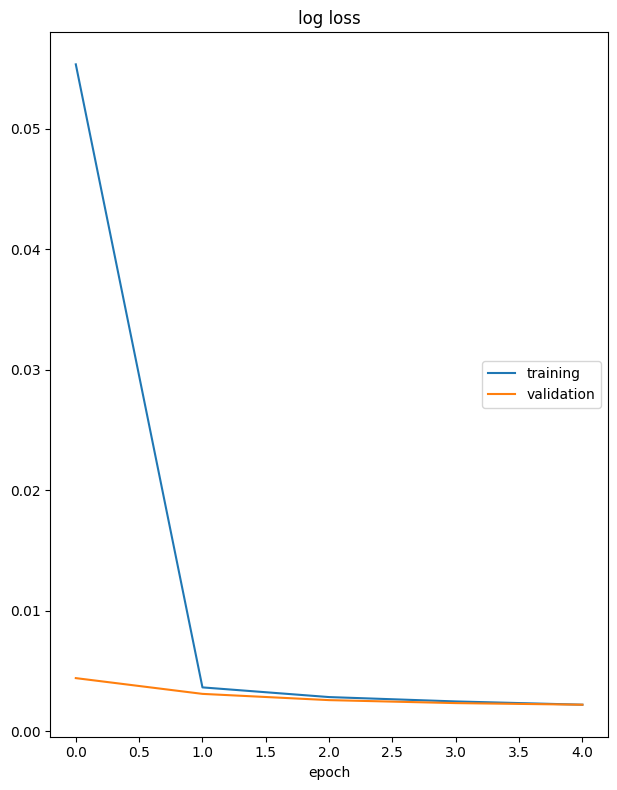

log loss
	training         	 (min:    0.002, max:    0.055, cur:    0.002)
	validation       	 (min:    0.002, max:    0.004, cur:    0.002)


In [35]:
# Ensure model is in training mode
liveloss = PlotLosses()    # plots evolution of loss and accuracy

# Set number of epochs and loop over them
n_epoch = 5
for epoch in range(n_epoch):

    logs = {}
    train_loss = train(model, optimiser, criterion, train_loader)
    val_loss = validate(model, criterion, val_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['val_log loss'] = val_loss.item()

    liveloss.update(logs)
    liveloss.draw()

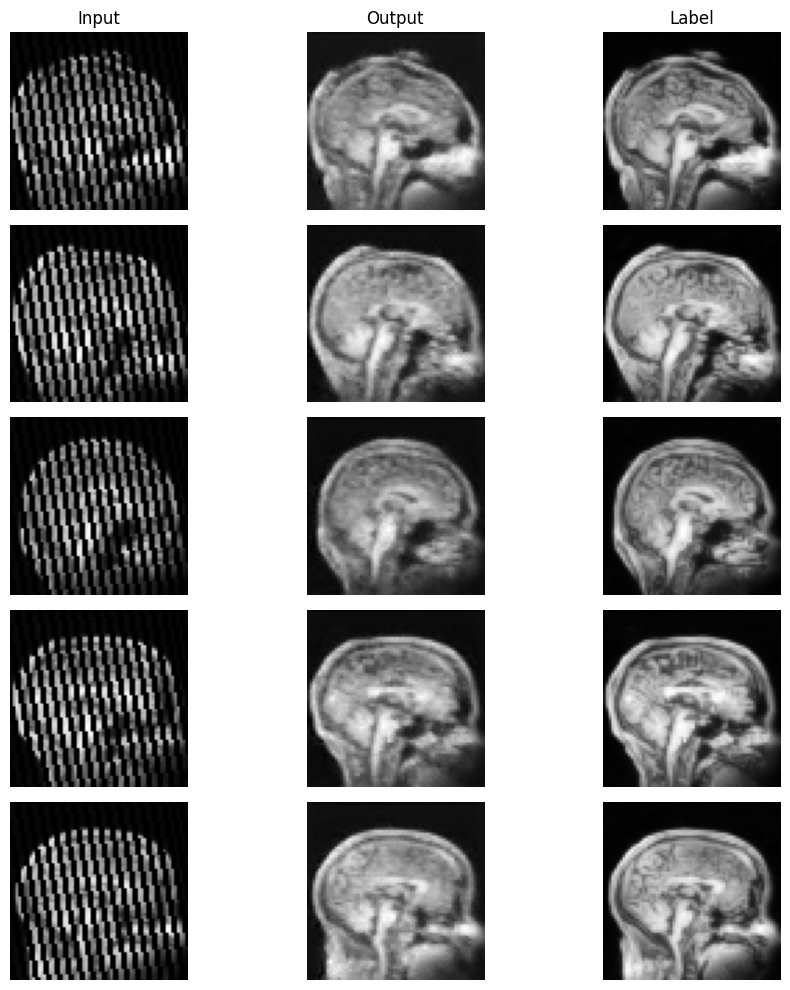

In [36]:
input, label = next(iter(train_loader))
label = label[:10].to(device)
input = input[:10].to(device)
output = model(input)

fig, axs = plt.subplots(5, 3, figsize=(10, 10))
for i in range(5):
    axs[i, 0].imshow(input.detach().cpu()[i][0], cmap='gray')
    axs[i, 0].axis('off')
    axs[0, 0].set_title('Input')

    axs[i, 1].imshow(output.detach().cpu()[i][0], cmap='gray')
    axs[i, 1].axis('off')
    axs[0, 1].set_title('Output')

    axs[i, 2].imshow(label.detach().cpu()[i][0], cmap='gray')
    axs[i, 2].axis('off')
    axs[0, 2].set_title('Label')

plt.tight_layout()
plt.show()

In this first iteration, we can see that the U-Net is able to perform well to uncorrupt the input dataset. However, we can see that the output images are not very sharp. For this reason, we can perform some hyperparameter tuning in hope of sharpening the image.

In order to obtain sharper images, we can look at


1.   The learning rate: This is a very critical hyperparameter which controls the step size in gradient descent. Lowering this parameter can help in finer adjustments in weights.
2.   Kernel size: the kernel size controls the size of the filter being applied. Naturally, if we apply a smaller filter to our image, we will be learning larger features. Thus lowering the kernel size can help potentially capture smaller features.
3.   The number of layers can be increased to be able to learn smaller details which might increase the sharpness. However this might also lead to overfitting and will increase the computational cost. For this reason we will not tune this hyperparameter



In [25]:
# ChatGPT was used to help write this code
!pip install optuna
import optuna

def objective(trial):
    # Define the search space
    lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
    kernel_size = trial.suggest_categorical('kernel_size', [2, 3, 4])
    #num_layers = trial.suggest_int('num_layers', 3, 7)

    # Build the model with suggested parameters
    model = Unet(n_channels=1, kernel_size=kernel_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model and compute the validation loss
    val_loss = validate(model, criterion, val_loader)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best parameters
print("Best parameters:", study.best_params)


[I 2024-12-06 16:48:22,564] A new study created in memory with name: no-name-64dbd48a-b898-4017-8a99-80ef89769ed3
<ipython-input-25-149b026a4582>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
[I 2024-12-06 16:49:03,418] Trial 0 finished with value: 0.3429787755012512 and parameters: {'learning_rate': 0.0007802028068567335, 'kernel_size': 3}. Best is trial 0 with value: 0.3429787755012512.
[I 2024-12-06 16:49:43,947] Trial 1 finished with value: 0.4517028331756592 and parameters: {'learning_rate': 2.3800406864406704e-05, 'kernel_size': 3}. Best is trial 0 with value: 0.3429787755012512.
[I 2024-12-06 16:50:24,720] Trial 2 finished with value: 0.41145211458206177 and parameters: {'learning_rate': 0.002261707312831869, 'kernel_size': 3}. Best is trial 0 with value: 0.34

Best parameters: {'learning_rate': 0.0007802028068567335, 'kernel_size': 3}


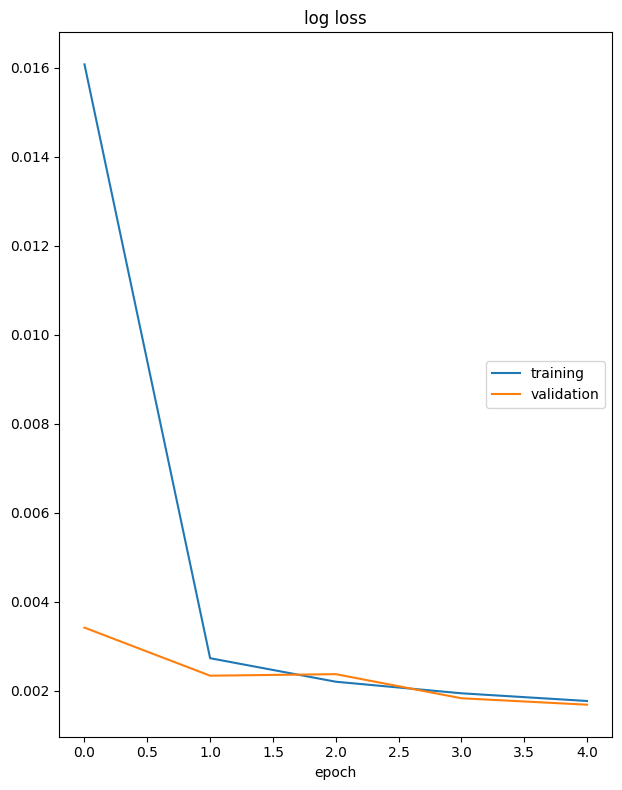

log loss
	training         	 (min:    0.002, max:    0.016, cur:    0.002)
	validation       	 (min:    0.002, max:    0.003, cur:    0.002)


In [26]:
# Creating U-Net with values from optuna

parameterised_model = Unet(n_channels = 1, kernel_size=3).to(device)
parameterised_optimiser = torch.optim.Adam(parameterised_model.parameters(), lr=0.00078)

liveloss = PlotLosses()

# Set number of epochs and loop over them
n_epoch = 5
for epoch in range(n_epoch):

    logs = {}
    train_loss = train(parameterised_model, parameterised_optimiser, criterion, train_loader)
    val_loss = validate(parameterised_model, criterion, val_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['val_log loss'] = val_loss.item()

    liveloss.update(logs)
    liveloss.draw()

The reason that the validation dataset has lower error in the first iteration could be because the hyperparameter tuning is based on the error of the validation set. Thus we begin with a error smaller than the train error, but the train error becomes lower from the 2nd epoch and onwards.

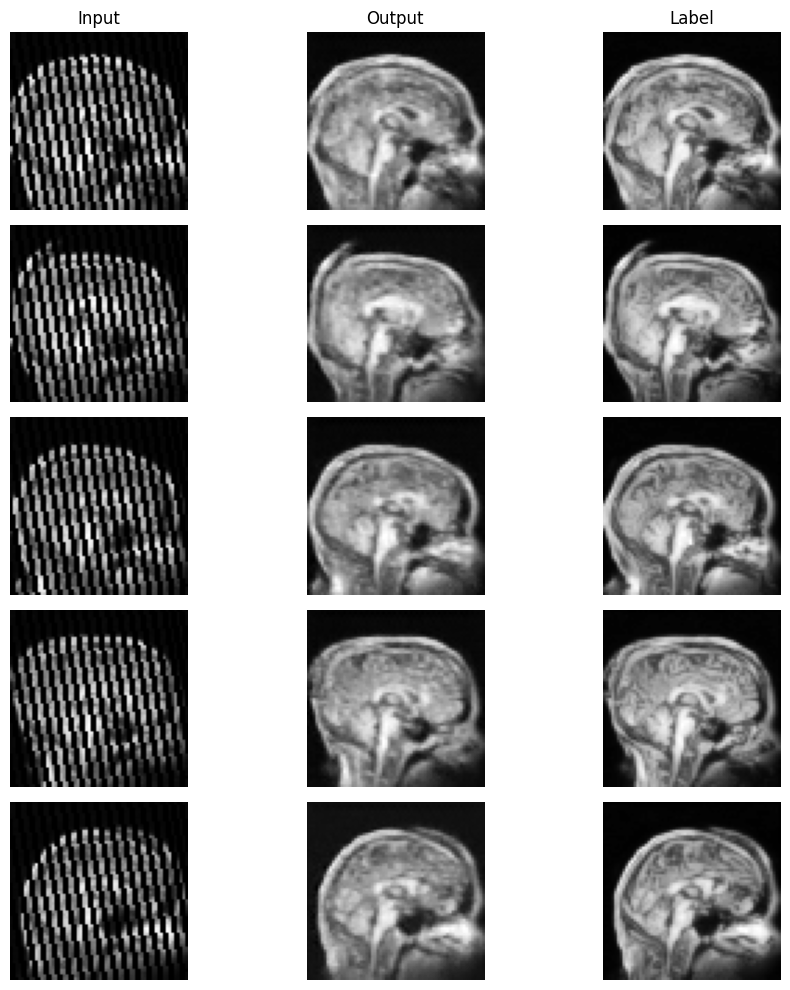

In [27]:
input, label = next(iter(train_loader))
label = label[:10].to(device)
input = input[:10].to(device)
output = parameterised_model(input)

fig, axs = plt.subplots(5, 3, figsize=(10, 10))
for i in range(5):
    axs[i, 0].imshow(input.detach().cpu()[i][0], cmap='gray')
    axs[i, 0].axis('off')
    axs[0, 0].set_title('Input')

    axs[i, 1].imshow(output.detach().cpu()[i][0], cmap='gray')
    axs[i, 1].axis('off')
    axs[0, 1].set_title('Output')

    axs[i, 2].imshow(label.detach().cpu()[i][0], cmap='gray')
    axs[i, 2].axis('off')
    axs[0, 2].set_title('Label')

plt.tight_layout()
plt.show()

As we can see, the results of the hyperparameter tuning yields slightly sharper results than the model we started out with. Thus we will use the tunes parameters as our final parameters.

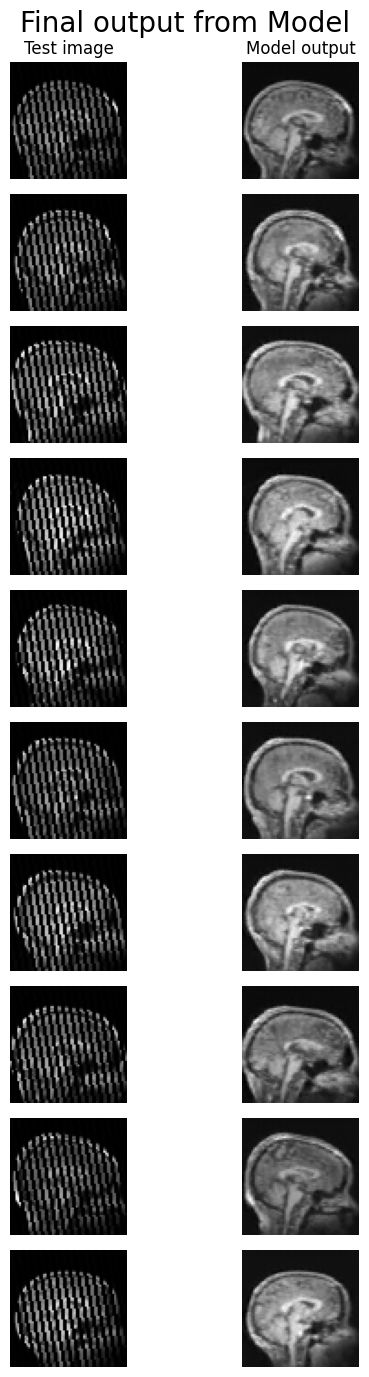

In [60]:
input = next(iter(test_loader)).to(device)
output_param = parameterised_model(input)
fig, axs = plt.subplots(10, 2, figsize=(6, 14))
for i in range(10):
    axs[i, 0].imshow(input.detach().cpu()[i][0], cmap='gray')
    axs[i, 0].axis('off')
    axs[0, 0].set_title('Test image')

    axs[i, 1].imshow(output_param.detach().cpu()[i][0], cmap='gray')
    axs[i, 1].axis('off')
    axs[0, 1].set_title('Model output')

plt.suptitle("Final output from Model", fontsize=20)
plt.tight_layout()
plt.show()

The output shows that the model is able to fill in the corrupted gaps fairly well. A main concern in this output is the sharpness of the image. There are several possible reasons for this:


*   The dataset of ~10000 images might still not be large enough for the model to be able to train and learn the intricate features.
*   The hyperparameter tuning involved only partial tuning of 2 parameters: the learning rate and the kernel size. While these are important parameters, there are other important parameters which should be explored, such as the number of layers. Furthermore, the hyperparameter tuning was only done on 10 tests due to the lack of time, but must be extended to a higher number.
*    The U-Net architecture is relatively a simple system. Given the current trend in the use of GANs and Diffusion models, these could potentially provide higher quality images.
*    There is an inherent drawback in using only the MSE as a loss function. It is known that the MSE does not have any structural awareness and does not exactly correlate with the human perception of detail. For this, it is a good idea to use another loss criterion, such as the SSIM ([SSIM](https://www.sciencedirect.com/science/article/pii/S0957417421014238)) which correlates better to human vision.







In [44]:
#!mkdir '/content/drive/MyDrive/models'

model_save_name = 'Assessment_model.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}"
path = F'./{model_save_name}'
torch.save(model.state_dict(), path)

optimiser_save_name = 'Assessment_optimiser.pt'
path = F"/content/gdrive/My Drive/models/{optimiser_save_name}"
path = F"./{optimiser_save_name}"
torch.save(model.state_dict(), path)

model_save_name = 'Assessment_param_model.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}"
path = F'./{model_save_name}'
torch.save(parameterised_model.state_dict(), path)

optimiser_save_name = 'Assessment_param_optimiser.pt'
path = F"/content/gdrive/My Drive/models/{optimiser_save_name}"
path = F"./{optimiser_save_name}"
torch.save(parameterised_model.state_dict(), path)

In [45]:
batch_size_test = 100
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [46]:
input_test = next(iter(test_loader)).to(device)
output_test = parameterised_model(input_test)

In [47]:
len(output_test.shape)
output_np = output_test.detach().cpu().numpy()
np.save("test_set_nogaps.npy", output_np)

In [61]:
# Check to confirm output data

transform = transforms.Compose([
    Lambda(lambda x: to_tensor(x)),
    transforms.Normalize((0.5,), (0.5,))  # Suitable for U-Net architecture
])

test_gap_dataset = MRI_test_dataset(root='/content/drive/MyDrive/', transform=transform)
test_nogap_dataset = MRI_test_dataset(root='/content/drive/MyDrive/Output_MRI', transform=transform)
print(test_gap_dataset)
print(test_nogap_dataset)

Found 4 .npy files in /content/drive/MyDrive/
Found 1 .npy files in /content/drive/MyDrive/Output_MRI
MRI_test_dataset
	len : 100
	root : /content/drive/MyDrive/
	transform : Compose(
    Lambda()
    Normalize(mean=(0.5,), std=(0.5,))
)
MRI_test_dataset
	len : 100
	root : /content/drive/MyDrive/Output_MRI
	transform : Compose(
    Lambda()
    Normalize(mean=(0.5,), std=(0.5,))
)


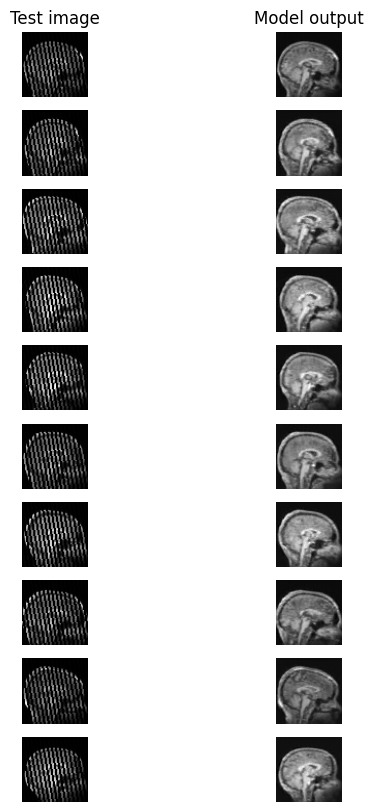

In [62]:
fig, axs = plt.subplots(10, 2, figsize=(6, 10))
for i in range(10):
    axs[i, 0].imshow(test_gap_dataset[i][0], cmap='gray')
    axs[i, 0].axis('off')
    axs[0, 0].set_title('Test image')

    axs[i, 1].imshow(test_nogap_dataset[i][0], cmap='gray')
    axs[i, 1].axis('off')
    axs[0, 1].set_title('Model output')

<br>

---

<br>